In [ ]:
base_path = "/content/drive/My Drive/Github/ca-hg-sbl-for-jadce-in-mtc"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')# Load saved data

Mounted at /content/drive


In [ ]:
!apt-get update
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,917 B in 1s (2,836 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (

Exception ignored in: <function NpzFile.__del__ at 0x788d8a9e14e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/numpy/lib/_npyio_impl.py", line 226, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/numpy/lib/_npyio_impl.py", line 221, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


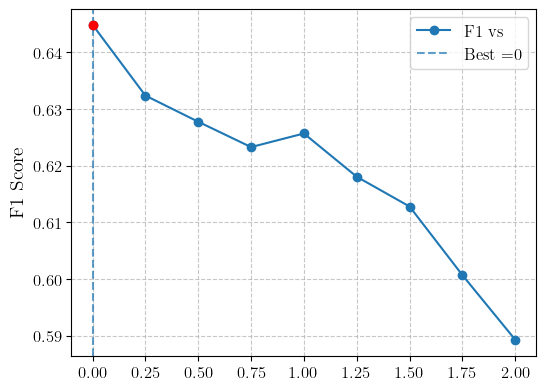

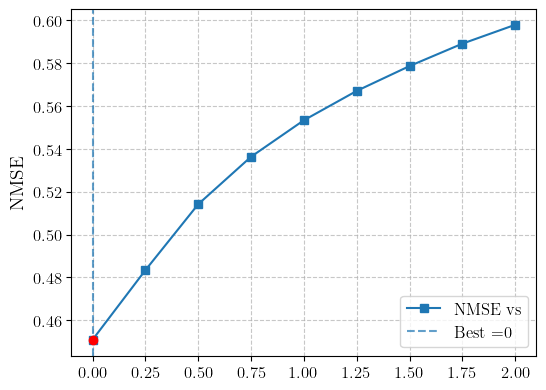

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
hp_folder = f"{base_path}/hyper_parameter_tuning/ca_hg_sbl_sic_b/data"
fig_dir   = f"{base_path}/hyper_parameter_tuning/ca_hg_sbl_sic_b/figures"

file_path  = f"{hp_folder}/ca_hg_sbl_sic_b_alpha_all_snr_db_12_pilot_length_25.npz"

alpha_values = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2], dtype=float)

# =========================
# Load ground truth
# =========================
all_gamma_true = np.load(f"{base_path}/communication_model/data/communication_simulation_gamma.npz",
                         allow_pickle=True)["all_gamma"][:100]  # (S, N)
all_z_true     = np.load(f"{base_path}/communication_model/data/communication_simulation_z.npz",
                         allow_pickle=True)["all_z"][:100]      # (S, N, M)

# =========================
# Helpers
# =========================
def parse_beta_from_filename(path):
    # finds "...beta_0_05..." -> 0.05
    m = re.search(r"beta_([0-9]+)_([0-9]+)", path)
    if not m: raise ValueError(f"Cannot parse beta from {path}")
    return float(f"{m.group(1)}.{m.group(2)}")

def gamma_object2bool(g_obj, tau=0.15):
    # object (S,K) of (N,) or numeric (S,K,N)
    if isinstance(g_obj, np.ndarray) and g_obj.dtype == object and g_obj.ndim == 2:
        S, K = g_obj.shape
        out = []
        # infer N
        for s in range(S):
            row = []
            for k in range(K):
                v = np.asarray(g_obj[s, k])
                if np.iscomplexobj(v): v = np.abs(v)
                else: v = v.astype(np.float64, copy=False)
                row.append(v > tau)
            out.append(np.stack(row, axis=0))  # (K,N)
        return np.stack(out, axis=0)  # (S,K,N)
    arr = np.asarray(g_obj)
    arr = np.abs(arr) if np.iscomplexobj(arr) else arr.astype(np.float64, copy=False)
    return arr > 0.15

def z_object2array(z_obj):
    # object (S,K) of (N,M) -> (S,K,N,M), else return numeric as-is
    if isinstance(z_obj, np.ndarray) and z_obj.dtype == object and z_obj.ndim == 2:
        S, K = z_obj.shape
        # infer (N,M)
        s0=k0=0
        while np.asarray(z_obj[s0,k0]).ndim==0:
            k0+=1
            if k0==K: s0+=1; k0=0
        n0 = np.asarray(z_obj[s0, k0])
        N, M = n0.shape
        out = np.zeros((S, K, N, M), dtype=n0.dtype)
        for s in range(S):
            for k in range(K):
                out[s, k] = np.asarray(z_obj[s, k])
        return out
    return np.asarray(z_obj)

def f1_from_gamma_bool(g_true, g_hat):
    TP = np.sum(g_hat & g_true); FP = np.sum(g_hat & (~g_true)); FN = np.sum((~g_hat) & g_true)
    p = TP/(TP+FP) if (TP+FP)>0 else 0.0; r = TP/(TP+FN) if (TP+FN)>0 else 0.0
    return (2*p*r/(p+r)) if (p+r)>0 else 0.0

def nmse_over_support(z_true, z_hat, g_true):
    A = np.where(g_true)[0]
    if A.size==0: return np.nan
    num = np.linalg.norm(z_true[A]-z_hat[A])**2
    den = np.linalg.norm(z_true[A])**2
    return num/den if den>0 else np.nan

def f1_vs_axis_bool(all_gamma_true, g_axis_bool):
    g_true = (all_gamma_true != 0)
    S, K, _ = g_axis_bool.shape
    out = np.zeros(K, float)
    for k in range(K):
        out[k] = np.mean([f1_from_gamma_bool(g_true[s], g_axis_bool[s,k]) for s in range(S)])
    return out

def nmse_vs_axis(all_z_true, all_gamma_true, z_axis):
    g_true = (all_gamma_true != 0)
    S, K, _, _ = z_axis.shape
    out = np.zeros(K, float)
    for k in range(K):
        vals=[]
        for s in range(S):
            n = nmse_over_support(all_z_true[s], z_axis[s,k], g_true[s])
            if not np.isnan(n): vals.append(n)
        out[k] = np.mean(vals) if vals else np.nan
    return out

# =========================
# Compute F1/NMSE over α
# =========================

d = np.load(file_path, allow_pickle=True)

g_soft = d["gamma_result_all"]   # (S,Kα) object of (N,) or numeric (S,Kα,N)
z_est  = d["z_result_all"]       # (S,Kα) object of (N,M) or numeric (S,Kα,N,M)

g_axis_bool = gamma_object2bool(g_soft, tau=0.15)   # (S,Kα,N)
z_axis      = z_object2array(z_est)                 # (S,Kα,N,M)

K_alpha = g_axis_bool.shape[1]
assert K_alpha == len(alpha_values), f"alpha_values length ({len(alpha_values)}) != K_alpha in file ({K_alpha})"

f1_curve   = f1_vs_axis_bool(all_gamma_true, g_axis_bool)     # (Kα,)
nmse_curve = nmse_vs_axis(all_z_true, all_gamma_true, z_axis) # (Kα,)

# Best α by each metric
best_f1_idx   = int(np.nanargmax(f1_curve))
best_nmse_idx = int(np.nanargmin(nmse_curve))
best_f1_alpha = alpha_values[best_f1_idx]
best_nmse_alpha = alpha_values[best_nmse_idx]

# =========================
# Plot params
# =========================
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
})

# --- F1 vs α ---
plt.figure(figsize=(6, 4.5))
plt.plot(alpha_values, f1_curve, marker='o', label='F1 vs')
plt.axvline(best_f1_alpha, linestyle='--', alpha=0.7, label=f'Best ={best_f1_alpha:g}')
plt.scatter([best_f1_alpha], [f1_curve[best_f1_idx]], c='r', zorder=3)
plt.xlabel(r''); plt.ylabel('F1 Score');
plt.xticks(alpha_values); plt.grid(True); plt.legend()
plt.savefig(f"{fig_dir}/alpha_sweep_f1.eps".replace('.', '_', 1), format='eps', bbox_inches='tight', dpi=300)
plt.show(); plt.close()

# --- NMSE vs α ---
plt.figure(figsize=(6, 4.5))
plt.plot(alpha_values, nmse_curve, marker='s', label='NMSE vs ')
plt.axvline(best_nmse_alpha, linestyle='--', alpha=0.7, label=f'Best ={best_nmse_alpha:g}')
plt.scatter([best_nmse_alpha], [nmse_curve[best_nmse_idx]], c='r', zorder=3)
plt.xlabel(r''); plt.ylabel('NMSE');
plt.xticks(alpha_values); plt.grid(True); plt.legend()
plt.savefig(f"{fig_dir}/alpha_sweep_nmse.eps".replace('.', '_', 1), format='eps', bbox_inches='tight', dpi=300)
plt.show(); plt.close()
